# Set up environment

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.9 MB/s eta 0:00:00


In [ ]:
from IPython.display import clear_output
# !pip3 install transformers
clear_output()

In [ ]:
import numpy as np

import torch
import torch.nn.functional as F
from torchvision import transforms

from transformers import pipeline
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

import requests
from PIL import Image
import urllib.parse as parse
import os

In [ ]:
# a function to determine whether a string is a URL or not
def is_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False

# a function to load an image
def load_image(image_path):
    """Helper function to load images from their URLs or paths."""
    if is_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)

# Load Image

In [ ]:
img_path = "https://shorthaircatbreeds.com/wp-content/uploads/2020/06/Urban-cat-crossing-a-road-300x180.jpg"
image = load_image(img_path)

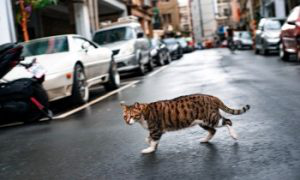

In [ ]:
image

In [ ]:
# convert PIL Image to pytorch tensors
transform = transforms.ToTensor()
image_tensor = image.convert("RGB")
image_tensor = transform(image_tensor)
image_tensor.shape

torch.Size([3, 180, 300])

# Helper functions

In [ ]:
def color_palette():
  """Color palette to map each class to its corresponding color."""
  return [[0, 128, 128],
          [255, 170, 0],
          [161, 19, 46],
          [118, 171, 47],
          [255, 255, 0],
          [84, 170, 127],
          [170, 84, 127],
          [33, 138, 200],
          [255, 84, 0],
          [255, 140, 208]]

In [ ]:
def overlay_segments(image, seg_mask):
  """Return different segments predicted by the model overlaid on image."""
  H, W = seg_mask.shape
  image_mask = np.zeros((H, W, 3), dtype=np.uint8)
  colors = np.array(color_palette())

  # convert to a pytorch tensor if seg_mask is not one already
  seg_mask = seg_mask if torch.is_tensor(seg_mask) else torch.tensor(seg_mask)
  unique_labels = torch.unique(seg_mask)

  # map each segment label to a unique color
  for i, label in enumerate(unique_labels):
    image_mask[seg_mask == label.item(), :] = colors[i]

  image = np.array(image)
  # percentage of original image in the final overlaid iamge
  img_weight = 0.5

  # overlay input image and the generated segment mask
  img = img_weight * np.array(image) * 255 + (1 - img_weight) * image_mask

  return img.astype(np.uint8)

In [ ]:
def replace_label(mask, label):
  """Replace the segment masks values with label."""
  mask = np.array(mask)
  mask[mask == 255] = label
  return mask

# Image segmentation using Hugging Face Pipeline

In [ ]:
# load the entire image segmentation pipeline
img_segmentation_pipeline = pipeline('image-segmentation',
                                     model="nvidia/segformer-b5-finetuned-ade-640-640")

/usr/local/lib/python3.8/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
output = img_segmentation_pipeline(image)
output

[{'score': None,
  'label': 'building',
  'mask': <PIL.Image.Image image mode=L size=300x180 at 0x7FC7FD201F40>},
 {'score': None,
  'label': 'floor',
  'mask': <PIL.Image.Image image mode=L size=300x180 at 0x7FC7FF4650D0>},
 {'score': None,
  'label': 'road',
  'mask': <PIL.Image.Image image mode=L size=300x180 at 0x7FC7FD2A0640>},
 {'score': None,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=300x180 at 0x7FC7FD2A0EE0>},
 {'score': None,
  'label': 'car',
  'mask': <PIL.Image.Image image mode=L size=300x180 at 0x7FC7FD2A06A0>},
 {'score': None,
  'label': 'plaything',
  'mask': <PIL.Image.Image image mode=L size=300x180 at 0x7FC90C2AFD00>},
 {'score': None,
  'label': 'minibike',
  'mask': <PIL.Image.Image image mode=L size=300x180 at 0x7FC90C2AFF70>}]

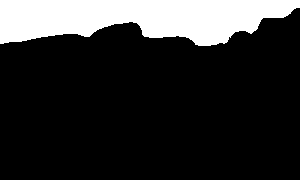

In [ ]:
output[0]['mask']

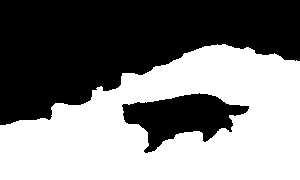

In [ ]:
output[2]['mask']

In [ ]:
# load the feature extractor (to preprocess images) and the model (to get outputs)
W, H = image.size
segmentation_mask = np.zeros((H, W), dtype=np.uint8)

for i in range(len(output)):
  segmentation_mask += replace_label(output[i]['mask'], i)

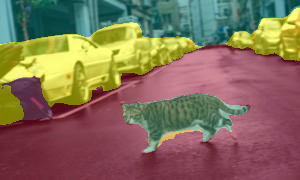

In [ ]:
# overlay the predicted segmentation masks on the original image
segmented_img = overlay_segments(image_tensor.permute(1, 2, 0), segmentation_mask)

# convert to PIL Image
Image.fromarray(segmented_img)

# Image segmentation using custom Hugging Face models

In [ ]:
# load the feature extractor (to preprocess images) and the model (to get outputs)
feature_extractor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")

In [ ]:
def to_tensor(image):
  """Convert PIL Image to pytorch tensor."""
  transform = transforms.ToTensor()
  image_tensor = image.convert("RGB")
  image_tensor = transform(image_tensor)
  return image_tensor

# a function that takes an image and return the segmented image
def get_segmented_image(model, feature_extractor, image_path):
  """Return the predicted segmentation mask for the input image."""
  # load the image
  image = load_image(image_path)
  # preprocess input
  inputs = feature_extractor(images=image, return_tensors="pt")
  # convert to pytorch tensor
  image_tensor = to_tensor(image)
  # pass the processed input to the model
  outputs = model(**inputs)
  print("outputs.logits.shape:", outputs.logits.shape)
  # interpolate output logits to the same shape as the input image
  upsampled_logits = F.interpolate(
      outputs.logits, # tensor to be interpolated
      size=image_tensor.shape[1:], # output size we want
      mode='bilinear', # do bilinear interpolation
      align_corners=False)

  # get the class with max probabilities
  segmentation_mask = upsampled_logits.argmax(dim=1)[0]
  print(f"{segmentation_mask.shape=}")
  # get the segmented image
  segmented_img = overlay_segments(image_tensor.permute(1, 2, 0), segmentation_mask)
  # convert to PIL Image
  return Image.fromarray(segmented_img)

outputs.logits.shape: torch.Size([1, 150, 160, 160])
segmentation_mask.shape=torch.Size([180, 300])


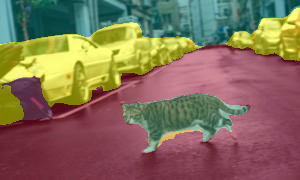

In [ ]:
get_segmented_image(model, feature_extractor, "https://shorthaircatbreeds.com/wp-content/uploads/2020/06/Urban-cat-crossing-a-road-300x180.jpg")

outputs.logits.shape: torch.Size([1, 150, 160, 160])
segmentation_mask.shape=torch.Size([480, 640])


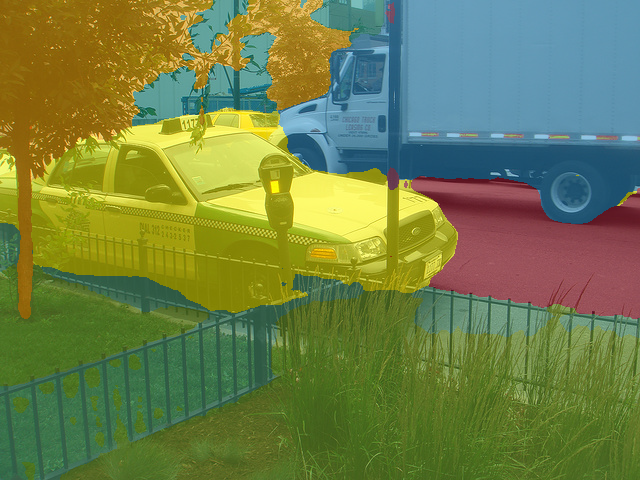

In [ ]:
get_segmented_image(model, feature_extractor, "http://images.cocodataset.org/test-stuff2017/000000000001.jpg")